# statistical analysis of inference results

In [1]:
import sys
sys.path.append('code/BalancingControl')

import recovery_utils as ru
import inference as inf

torch threads 1
Running on device cpu


In [2]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
import json
import gc

In [3]:
results_folder = "results"
inference_folder = os.path.join(results_folder, "inference")

mask_file_name = "mask.txt"
processed_data_folder = os.path.join(results_folder, "processed_data")
mask_file = os.path.join(processed_data_folder, mask_file_name)

processed_data_folder = os.path.join(results_folder, "processed_data")

full_data_fname = "full_data.csv"
full_data_file = os.path.join(processed_data_folder, full_data_fname)

full_data_df = pd.read_csv(full_data_file)

n_agents = 188

In [4]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, "rb") as f:
    all_mask = pickle.load(f)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask).permute((1,0))
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.9766)


/tmp/ipykernel_16386/1548601007.py:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  exp_mask = torch.tensor(all_mask).permute((1,0))


In [5]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

In [6]:
def convert_data_for_agent(full_data_df):

    mask = full_data_df.loc[(full_data_df["step_index"]==1)]
    mask_formatted = torch.stack([torch.from_numpy(mask.loc[mask["subject"]==i]["mask"].to_numpy()) for i in range(n_agents)])

    actions1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    actions1_formatted = torch.stack([torch.from_numpy(actions1.loc[actions1["subject"]==i]["first_stage_actions"].to_numpy()) for i in range(n_agents)])

    actions2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    actions2_formatted = torch.stack([torch.from_numpy(actions2.loc[actions2["subject"]==i]["second_stage_actions"].to_numpy()) for i in range(n_agents)])

    print("possible actions1", torch.unique(actions1_formatted[mask_formatted]))
    print("possible actions2", torch.unique(actions2_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    actions1_formatted = torch.where(mask_formatted, actions1_formatted, -1)
    actions2_formatted = torch.where(mask_formatted, actions2_formatted, -1)

    actions = torch.stack([actions1_formatted, actions2_formatted], dim=-1).permute((1,2,0))
    #print(actions.permute((0,2,1))[mask_formatted])
    # agent counts from zero:
    actions = actions-1.

    states1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    # agent counts from zero, hence -1 at the end:
    states1_formatted = torch.stack([torch.from_numpy(states1.loc[states1["subject"]==i]["first_stage_states"].to_numpy()) for i in range(n_agents)]) - 1
     
    states2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    # agent counts from zero, hence -1 at the end:
    states2_formatted = torch.stack([torch.from_numpy(states2.loc[states2["subject"]==i]["second_stage_states"].to_numpy()) for i in range(n_agents)]) - 1

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    states1_formatted = torch.where(mask_formatted, states1_formatted, -1)
    states2_formatted = torch.where(mask_formatted, states2_formatted, -1)
    # create third time step states:
    states3_formatted = states2_formatted+2 + (actions2_formatted-1)*2
    states3_formatted = torch.where(mask_formatted, states3_formatted, -1)


    print("possible states1", torch.unique(states1_formatted[mask_formatted]))
    print("possible states2", torch.unique(states2_formatted[mask_formatted]))
    print("possible states3", torch.unique(states3_formatted[mask_formatted]))

    states = torch.stack([states1_formatted, states2_formatted, states3_formatted], dim=-1).permute((1,2,0))

    # agent views r=2 as "no reward", may instead give negative reward as in Otto et al:
    rewards1_formatted = torch.zeros_like(states1_formatted) #+ 2

    rewards2_formatted = rewards1_formatted

    # create third time step rewards = second stage rewards:
    rewards3 = full_data_df.loc[(full_data_df["step_index"]==2)]
    rewards3_formatted = torch.stack([torch.from_numpy(rewards3.loc[rewards3["subject"]==i]["second_stage_rewards"].to_numpy()) for i in range(n_agents)])

    print("possible rewards1", torch.unique(rewards1_formatted[mask_formatted]))
    print("possible rewards2", torch.unique(rewards2_formatted[mask_formatted]))
    print("possible rewards3", torch.unique(rewards3_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    rewards1_formatted = torch.where(mask_formatted, rewards1_formatted, -1)
    rewards2_formatted = torch.where(mask_formatted, rewards2_formatted, -1)
    rewards3_formatted = torch.where(mask_formatted, rewards3_formatted, -1)

    rewards = torch.stack([rewards1_formatted, rewards2_formatted, rewards3_formatted], dim=-1).permute((1,2,0))


    data_dict = {"observations": states.long(), "rewards": rewards.long(), "actions": actions.long(), "valid": mask_formatted.permute((1,0))}

    return data_dict

data = convert_data_for_agent(full_data_df)

possible actions1 tensor([1., 2.], dtype=torch.float64)
possible actions2 tensor([1., 2.], dtype=torch.float64)
possible states1 tensor([0.], dtype=torch.float64)
possible states2 tensor([1., 2.], dtype=torch.float64)
possible states3 tensor([3., 4., 5., 6.], dtype=torch.float64)
possible rewards1 tensor([0.], dtype=torch.float64)
possible rewards2 tensor([0.], dtype=torch.float64)
possible rewards3 tensor([0., 1.], dtype=torch.float64)


In [7]:
def load_BCC_results(infer_h, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    bayes_agent = ru.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df = ru.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df = ru.load_samples(base_dir, fname_str) 

    return mean_df, sample_df

BCC_3param_inference_
analyzing 188 data sets


/home/sarah/src/BayesianTwoStageTaskAnalysis/code/BalancingControl/perception.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1707782759820/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


<Figure size 640x480 with 0 Axes>

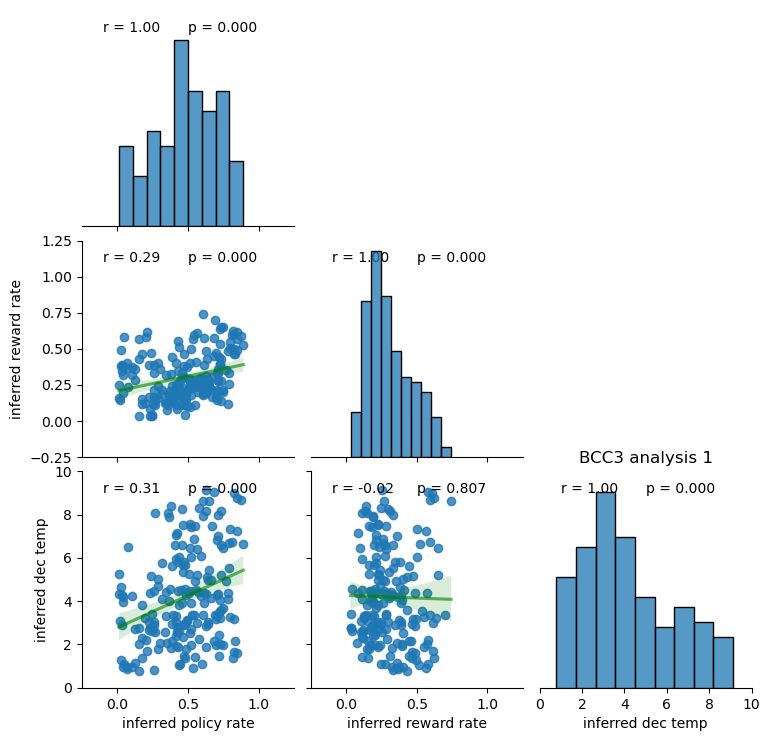

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_3param) with 188 agents.
The settings are: infer h False


In [8]:
# BCC3 analysis 1

infer_h = False

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC3_1_mean_df, BCC3_1_sample_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_1_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(ru.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

BCC2_3param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

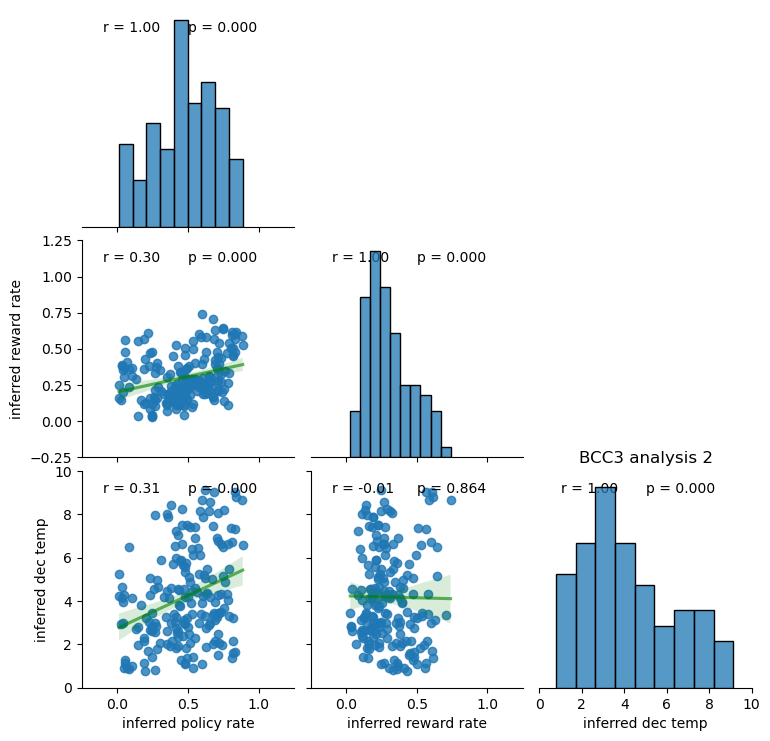

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC2_3param) with 188 agents.
The settings are: infer h False


In [9]:
# BCC3 analysis 2

infer_h = False

prefix = "BCC2_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC3_2_mean_df, BCC3_2_sample_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_2_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
f.map(ru.annot_corrfunc)
plt.title("BCC3 analysis 2")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

Index(['Unnamed: 0 analysis 1', 'inferred policy rate analysis 1',
       'subject analysis 1', 'inferred reward rate analysis 1',
       'inferred dec temp analysis 1', 'Unnamed: 0 analysis 2',
       'inferred policy rate analysis 2', 'subject analysis 2',
       'inferred reward rate analysis 2', 'inferred dec temp analysis 2'],
      dtype='object')
['Unnamed: 0 analysis 1', 'inferred policy rate analysis 1', 'subject analysis 1', 'inferred reward rate analysis 1', 'inferred dec temp analysis 1']


<Figure size 640x480 with 0 Axes>

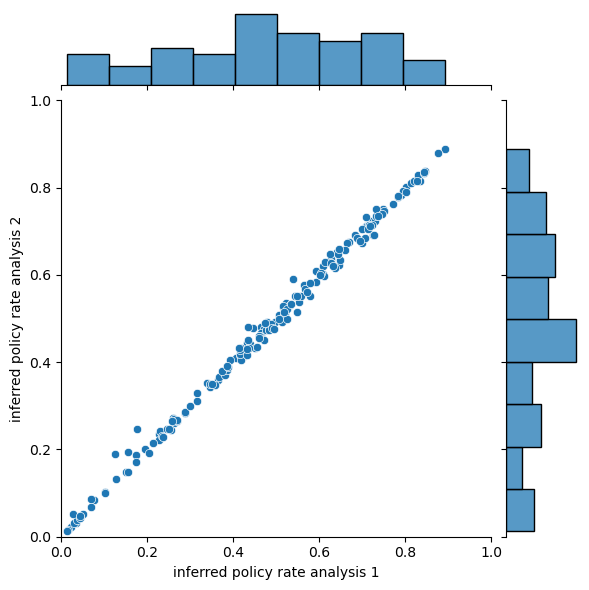

<Figure size 640x480 with 0 Axes>

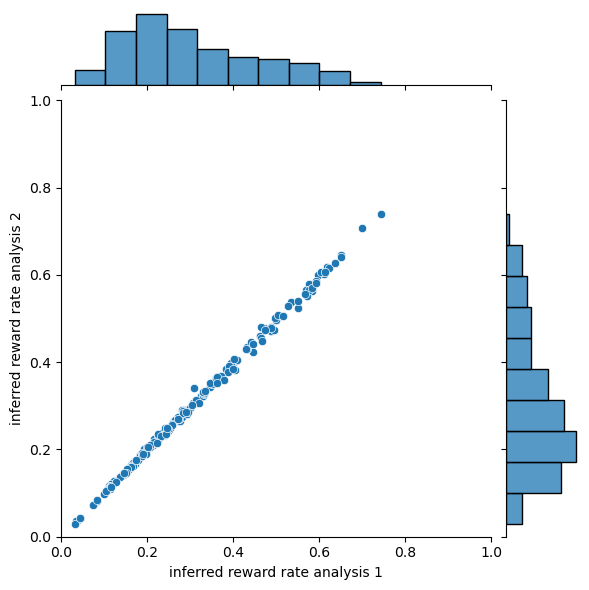

<Figure size 640x480 with 0 Axes>

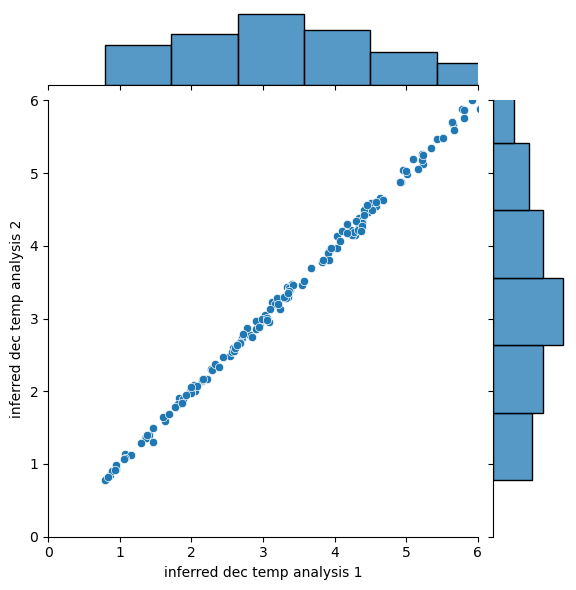

In [10]:
# compare the two results

concat_keys_a1 = [name+" analysis 1" for name in BCC3_1_mean_df.keys()]
concat_keys_a2 = [name+" analysis 2" for name in BCC3_2_mean_df.keys()]

new_name_dict_a1 = {BCC3_1_mean_df.keys()[i]: concat_keys_a1[i] for i in range(len(concat_keys_a1))}
new_name_dict_a2 = {BCC3_2_mean_df.keys()[i]: concat_keys_a2[i] for i in range(len(concat_keys_a2))}

renamed_a1 = BCC3_1_mean_df.rename(columns=new_name_dict_a1)
renamed_a2 = BCC3_2_mean_df.rename(columns=new_name_dict_a2)

BCC3_means_df = pd.concat([renamed_a1, renamed_a2], axis='columns')#, join="inner")

print(BCC3_means_df.keys())

print(concat_keys_a1)
a1_vars_of_interest = ["inferred "+name+" analysis 1" for name in param_names]
a2_vars_of_interest = ["inferred "+name+" analysis 2" for name in param_names]

#plt.figure()
##sns.relplot(data=BCC3_means_df, )
#sns.pairplot(data=BCC3_means_df, x_vars=a1_vars_of_interest, y_vars=a2_vars_of_interest)#, x_vars = )
#plt.show()

for i, name in enumerate(param_names):
    plt.figure()
    #sns.scatterplot(data=BCC3_means_df, x="inferred "+name+" analysis 1", y="inferred "+name+" analysis 2")
    sns.jointplot(data=BCC3_means_df, x="inferred "+name+" analysis 1", y="inferred "+name+" analysis 2")
    plt.xlim(param_ranges[i])
    plt.ylim(param_ranges[i])
    plt.show()

BCC_4param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

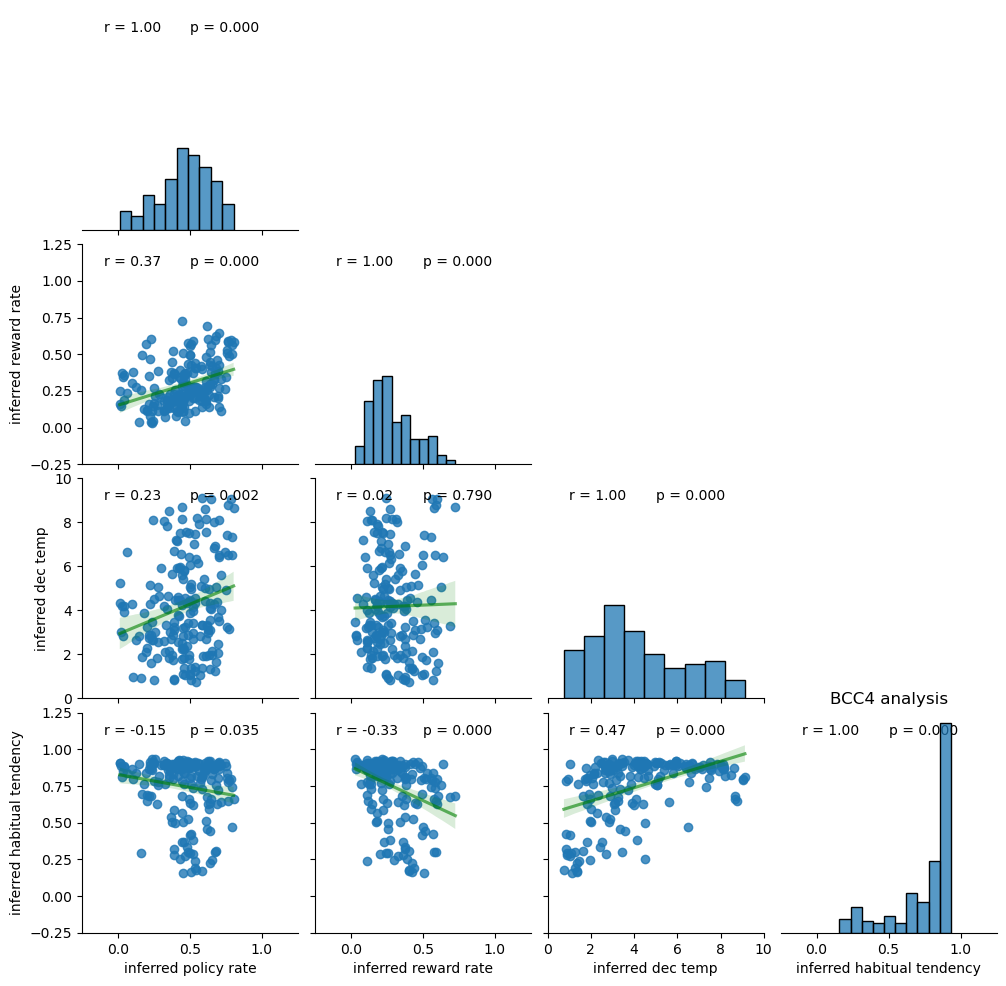

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_4param) with 188 agents.
The settings are: infer h True


In [11]:
# BCC4 analysis

infer_h = True

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC4_mean_df, BCC4_sample_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

BCC_param_ranges = [[0,1], [0,1], [0,max_dt], [0,1]]
BCC_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10], [-0.25,1.25]]
BCC_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(ru.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

Index(['Unnamed: 0 BCC3', 'inferred policy rate BCC3', 'subject BCC3',
       'inferred reward rate BCC3', 'inferred dec temp BCC3',
       'Unnamed: 0 BCC4', 'inferred policy rate BCC4', 'subject BCC4',
       'inferred reward rate BCC4', 'inferred dec temp BCC4',
       'inferred habitual tendency BCC4'],
      dtype='object')
['Unnamed: 0 BCC3', 'inferred policy rate BCC3', 'subject BCC3', 'inferred reward rate BCC3', 'inferred dec temp BCC3']
['Unnamed: 0 BCC4', 'inferred policy rate BCC4', 'subject BCC4', 'inferred reward rate BCC4', 'inferred dec temp BCC4', 'inferred habitual tendency BCC4']
Index(['Unnamed: 0 BCC4', 'inferred policy rate BCC4', 'subject BCC4',
       'inferred reward rate BCC4', 'inferred dec temp BCC4',
       'inferred habitual tendency BCC4'],
      dtype='object')


<Figure size 640x480 with 0 Axes>

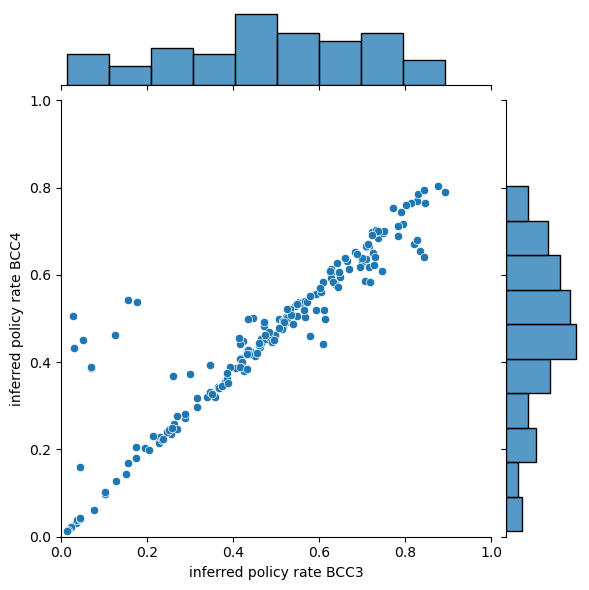

<Figure size 640x480 with 0 Axes>

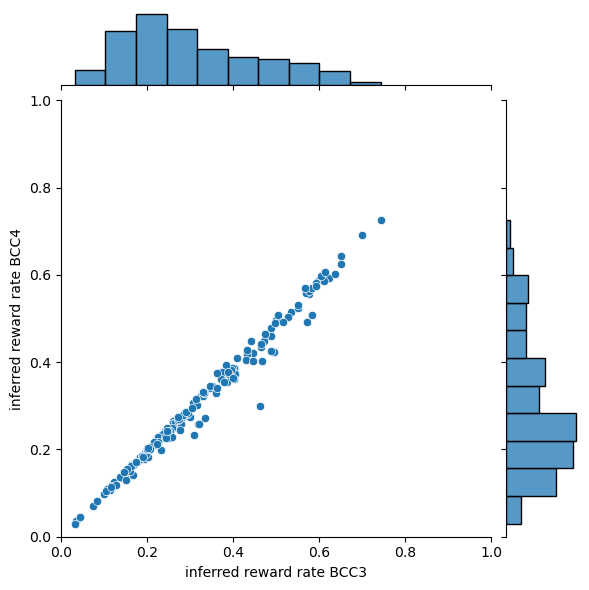

<Figure size 640x480 with 0 Axes>

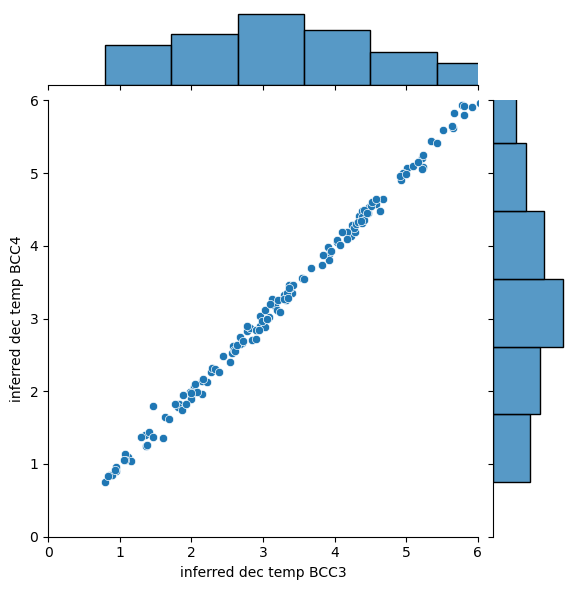

In [12]:
# compare the two results

concat_keys_BCC3 = [name+" BCC3" for name in BCC3_1_mean_df.keys()]
concat_keys_BCC4 = [name+" BCC4" for name in BCC4_mean_df.keys()]

new_name_dict_BCC3 = {BCC3_1_mean_df.keys()[i]: concat_keys_BCC3[i] for i in range(len(concat_keys_BCC3))}
new_name_dict_BCC4 = {BCC4_mean_df.keys()[i]: concat_keys_BCC4[i] for i in range(len(concat_keys_BCC4))}

renamed_BCC3 = BCC3_1_mean_df.rename(columns=new_name_dict_BCC3)
renamed_BCC4 = BCC4_mean_df.rename(columns=new_name_dict_BCC4)

BCC_means_df = pd.concat([renamed_BCC3, renamed_BCC4], axis='columns')#, join="inner")

print(BCC_means_df.keys())

print(concat_keys_BCC3)
print(concat_keys_BCC4)
print(renamed_BCC4.keys())

BCC3_vars_of_interest = ["inferred "+name+" BCC3" for name in param_names[:-1]]
BCC4_vars_of_interest = ["inferred "+name+" BCC4" for name in param_names]

#plt.figure()
##sns.relplot(data=BCC3_means_df, )
#sns.pairplot(data=BCC3_means_df, x_vars=a1_vars_of_interest, y_vars=a2_vars_of_interest)#, x_vars = )
#plt.show()

for i, name in enumerate(BCC_param_names[:-1]):
    plt.figure()
    #sns.scatterplot(data=BCC3_means_df, x="inferred "+name+" analysis 1", y="inferred "+name+" analysis 2")
    sns.jointplot(data=BCC_means_df, x="inferred "+name+" BCC3", y="inferred "+name+" BCC4")
    plt.xlim(BCC_param_ranges[i])
    plt.ylim(BCC_param_ranges[i])
    #plt.title("inferred "+name+" BCC3 + inferred "+name+" BCC4")
    plt.show()

#for i, name in enumerate(param_names[:-1]):
#    plt.figure()
#    #sns.scatterplot(data=BCC3_means_df, x="inferred "+name+" analysis 1", y="inferred "+name+" analysis 2")
#    sns.jointplot(data=BCC_means_df, x="inferred "+name+" BCC3", y="inferred habitual tendency BCC4")
#    plt.xlim(param_ranges[i])
#    #plt.ylim(param_ranges[i])
#    plt.show()

In [13]:
def load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    mfmb_agent = ru.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(mfmb_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df = ru.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df = ru.load_samples(base_dir, fname_str) 

    return mean_df, sample_df

mbmf_4param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

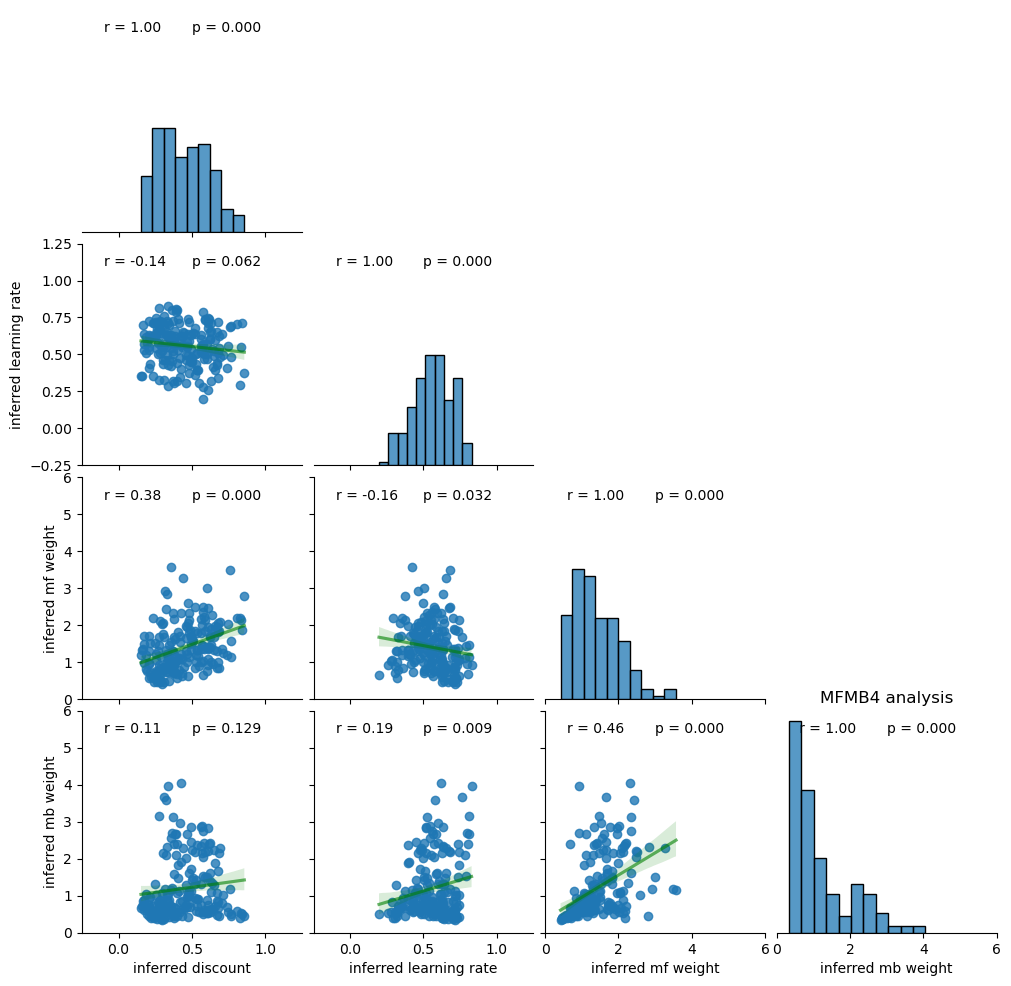

This is inference for the twostage task using the two beta mbmf model(mbmf_4param) with 188 agents.
The settings are: use p False


In [14]:
# MFMB4 analysis

# set parameters and their names

use_orig = False

use_p = False
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB4_mean_df, MFMB4_sample_df = load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, param_names)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(ru.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

mbmf_5param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

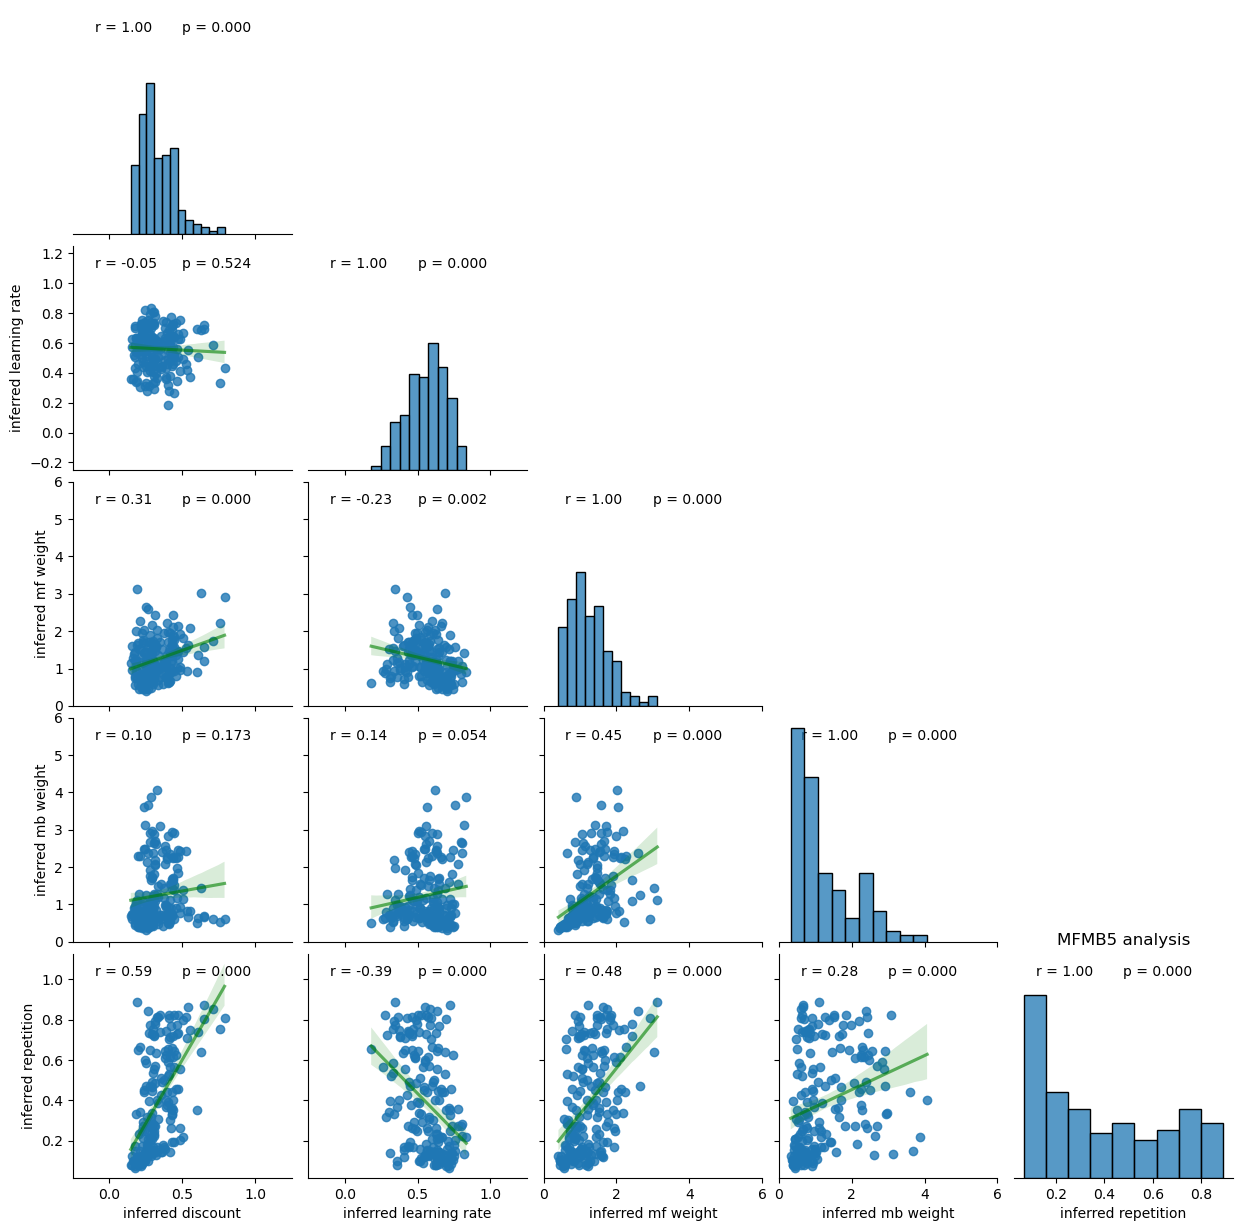

This is inference for the twostage task using the two beta mbmf model(mbmf_5param) with 188 agents.
The settings are: use p True


In [15]:
# MFMB5 analysis

# set parameters and their names

use_orig = False

use_p = True
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB5_mean_df, MFMB5_sample_df = load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, param_names)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(ru.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

Index(['Unnamed: 0 MFMB4', 'inferred discount MFMB4', 'subject MFMB4',
       'inferred learning rate MFMB4', 'inferred mf weight MFMB4',
       'inferred mb weight MFMB4', 'Unnamed: 0 MFMB5',
       'inferred discount MFMB5', 'subject MFMB5',
       'inferred learning rate MFMB5', 'inferred mf weight MFMB5',
       'inferred mb weight MFMB5', 'inferred repetition MFMB5'],
      dtype='object')
['Unnamed: 0 MFMB4', 'inferred discount MFMB4', 'subject MFMB4', 'inferred learning rate MFMB4', 'inferred mf weight MFMB4', 'inferred mb weight MFMB4']
['Unnamed: 0 MFMB5', 'inferred discount MFMB5', 'subject MFMB5', 'inferred learning rate MFMB5', 'inferred mf weight MFMB5', 'inferred mb weight MFMB5', 'inferred repetition MFMB5']
Index(['Unnamed: 0 MFMB4', 'inferred discount MFMB4', 'subject MFMB4',
       'inferred learning rate MFMB4', 'inferred mf weight MFMB4',
       'inferred mb weight MFMB4'],
      dtype='object')


<Figure size 640x480 with 0 Axes>

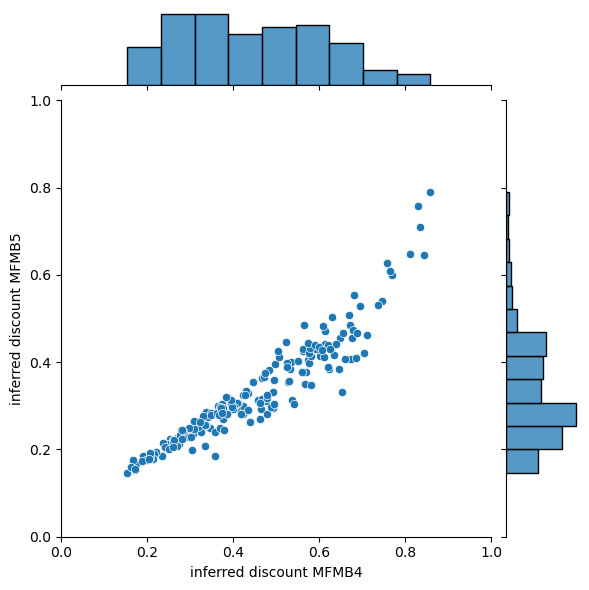

<Figure size 640x480 with 0 Axes>

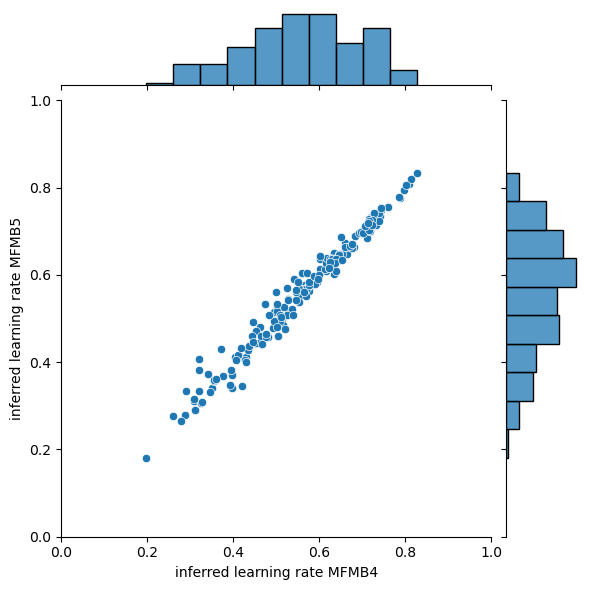

<Figure size 640x480 with 0 Axes>

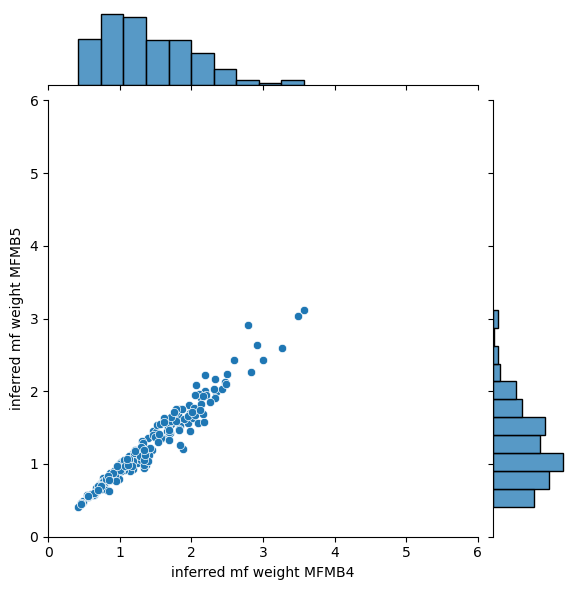

<Figure size 640x480 with 0 Axes>

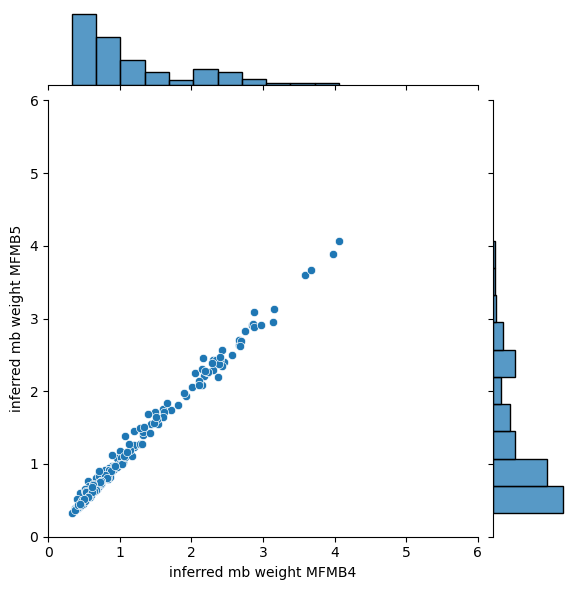

In [16]:
# compare the two results

concat_keys_MFMB4 = [name+" MFMB4" for name in MFMB4_mean_df.keys()]
concat_keys_MFMB5 = [name+" MFMB5" for name in MFMB5_mean_df.keys()]

new_name_dict_MFMB4 = {MFMB4_mean_df.keys()[i]: concat_keys_MFMB4[i] for i in range(len(concat_keys_MFMB4))}
new_name_dict_MFMB5 = {MFMB5_mean_df.keys()[i]: concat_keys_MFMB5[i] for i in range(len(concat_keys_MFMB5))}

renamed_MFMB4 = MFMB4_mean_df.rename(columns=new_name_dict_MFMB4)
renamed_MFMB5 = MFMB5_mean_df.rename(columns=new_name_dict_MFMB5)

MFMB_means_df = pd.concat([renamed_MFMB4, renamed_MFMB5], axis='columns')#, join="inner")

print(MFMB_means_df.keys())

print(concat_keys_MFMB4)
print(concat_keys_MFMB5)
print(renamed_MFMB4.keys())

for i, name in enumerate(MFMB_param_names[:-1]):
    plt.figure()
    sns.jointplot(data=MFMB_means_df, x="inferred "+name+" MFMB4", y="inferred "+name+" MFMB5")
    plt.xlim(MFMB_param_ranges[i])
    plt.ylim(MFMB_param_ranges[i])
    plt.show()

Index(['Unnamed: 0 BCC3', 'inferred policy rate BCC3', 'subject BCC3',
       'inferred reward rate BCC3', 'inferred dec temp BCC3',
       'Unnamed: 0 MFMB4', 'inferred discount MFMB4', 'subject MFMB4',
       'inferred learning rate MFMB4', 'inferred mf weight MFMB4',
       'inferred mb weight MFMB4'],
      dtype='object')
['inferred policy rate BCC3', 'inferred reward rate BCC3', 'inferred dec temp BCC3']
['inferred discount MFMB4', 'inferred learning rate MFMB4', 'inferred mf weight MFMB4', 'inferred mb weight MFMB4']


<Figure size 640x480 with 0 Axes>

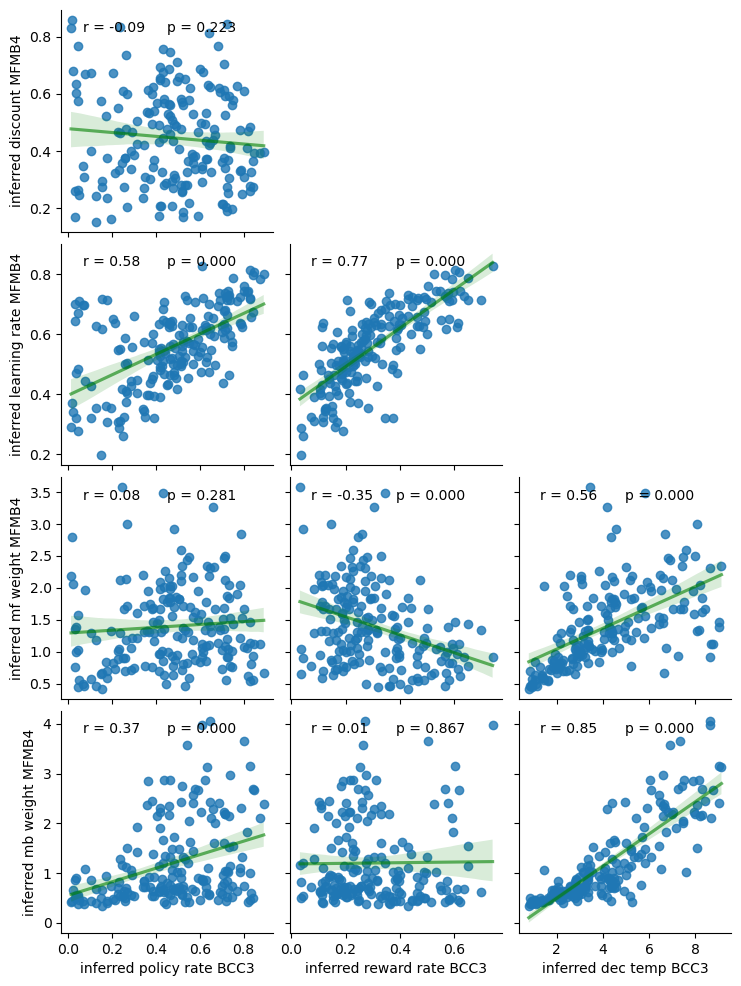

In [17]:
# compare BCC and MBMF4 results

BCC3_MBMF4_means_df = pd.concat([renamed_BCC3, renamed_MFMB4], axis='columns')#, join="inner")

print(BCC3_MBMF4_means_df.keys())

y_vars_of_interest = ["inferred "+name+" MFMB4" for name in MFMB_param_names[:-1]]
x_vars_of_interest = ["inferred "+name+" BCC3" for name in BCC_param_names[:-1]]

print(x_vars_of_interest)
print(y_vars_of_interest)

plt.figure()
f = sns.pairplot(data=BCC3_MBMF4_means_df, kind='reg', corner=True,#, diag_kind="hist"
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    y_vars=y_vars_of_interest,
                    x_vars=x_vars_of_interest)
f.map(ru.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[3,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        

Index(['Unnamed: 0 BCC3', 'inferred policy rate BCC3', 'subject BCC3',
       'inferred reward rate BCC3', 'inferred dec temp BCC3',
       'Unnamed: 0 MFMB5', 'inferred discount MFMB5', 'subject MFMB5',
       'inferred learning rate MFMB5', 'inferred mf weight MFMB5',
       'inferred mb weight MFMB5', 'inferred repetition MFMB5'],
      dtype='object')
['inferred policy rate BCC3', 'inferred reward rate BCC3', 'inferred dec temp BCC3']
['inferred discount MFMB5', 'inferred learning rate MFMB5', 'inferred mf weight MFMB5', 'inferred mb weight MFMB5', 'inferred repetition MFMB5']


<Figure size 640x480 with 0 Axes>

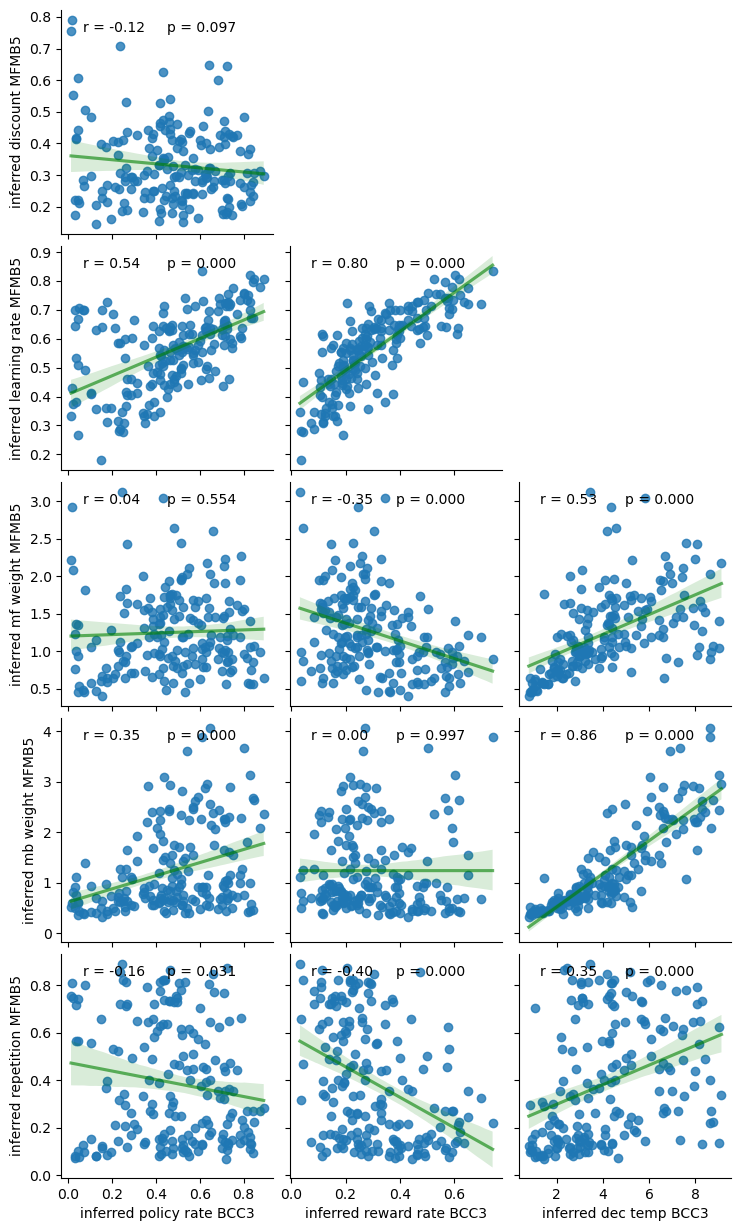

In [18]:
# compare BCC and MBMF5 results

BCC3_MBMF5_means_df = pd.concat([renamed_BCC3, renamed_MFMB5], axis='columns')#, join="inner")

print(BCC3_MBMF5_means_df.keys())

y_vars_of_interest = ["inferred "+name+" MFMB5" for name in MFMB_param_names]
x_vars_of_interest = ["inferred "+name+" BCC3" for name in BCC_param_names[:-1]]

print(x_vars_of_interest)
print(y_vars_of_interest)

plt.figure()
f = sns.pairplot(data=BCC3_MBMF5_means_df, kind='reg', corner=True,#, diag_kind="hist"
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    y_vars=y_vars_of_interest,
                    x_vars=x_vars_of_interest)
f.map(ru.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[3,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        